 Import libraries

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/Final_processed_dataset'

"""### Training with ResNet50"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import json
import cv2
from collections import defaultdict
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"Is CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")


import os
import shutil
import time

# Define the local path to store the dataset
local_dataset_path = '/tmp/dental_dataset'

# Check if data was already copied
if not os.path.exists(local_dataset_path):
    os.makedirs(local_dataset_path, exist_ok=True)

    print("Copying dataset from Google Drive to local storage...")
    start_time = time.time()

    # Create train directory
    os.makedirs(os.path.join(local_dataset_path, 'train'), exist_ok=True)

    # Copy annotation file
    src_annotation = os.path.join(dataset_path, 'train', '_annotations_augmented.json')
    dst_annotation = os.path.join(local_dataset_path, 'train', '_annotations_augmented.json')
    shutil.copy2(src_annotation, dst_annotation)

    # Get list of image files from annotations
    import json
    with open(src_annotation, 'r') as f:
        data = json.load(f)

    # Copy only required image files
    image_files = [img['file_name'] for img in data['images']]
    print(f"Copying {len(image_files)} image files...")

    for i, img_file in enumerate(image_files):
        if i % 100 == 0:
            print(f"Copied {i}/{len(image_files)} files...")

        src_img = os.path.join(dataset_path, 'train', img_file)
        dst_img = os.path.join(local_dataset_path, 'train', img_file)
        shutil.copy2(src_img, dst_img)

    elapsed = time.time() - start_time
    print(f"Dataset copying completed in {elapsed:.2f} seconds")
else:
    print(f"Using existing local dataset at {local_dataset_path}")

# Then update your dataset_path to use the local path
dataset_path = local_dataset_path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Is CUDA available: True
GPU name: NVIDIA A100-SXM4-40GB
Copying dataset from Google Drive to local storage...
Copying 11396 image files...
Copied 0/11396 files...
Copied 100/11396 files...
Copied 200/11396 files...
Copied 300/11396 files...
Copied 400/11396 files...
Copied 500/11396 files...
Copied 600/11396 files...
Copied 700/11396 files...
Copied 800/11396 files...
Copied 900/11396 files...
Copied 1000/11396 files...
Copied 1100/11396 files...
Copied 1200/11396 files...
Copied 1300/11396 files...
Copied 1400/11396 files...
Copied 1500/11396 files...
Copied 1600/11396 files...
Copied 1700/11396 files...
Copied 1800/11396 files...
Copied 1900/11396 files...
Copied 2000/11396 files...
Copied 2100/11396 files...
Copied 2200/11396 files...
Copied 2300/11396 files...
Copied 2400/11396 files...
Copied 2500/11396 files...
Copied 2600/11396 files

Define Focal Loss and Dataset class

In [ ]:
class FocalLoss(nn.Module):
    """Focal Loss implementation for handling class imbalance"""
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss

class DentalDataset(Dataset):
    """PyTorch Dataset for dental X-ray images"""
    def __init__(self, annotations, images_dir, transform=None):
        self.annotations = annotations
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]

        # Load image
        img_path = os.path.join(self.images_dir, ann['img_file'])
        image = cv2.imread(img_path)

        if image is None:
            # Return a dummy image if loading fails
            image = np.zeros((224, 224, 3), dtype=np.uint8)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Crop with bounding box
            x, y, w, h = map(int, ann['bbox'])
            cropped = image[y:y+h, x:x+w]

            if cropped.size == 0:
                image = np.zeros((224, 224, 3), dtype=np.uint8)
            else:
                image = cv2.resize(cropped, (224, 224))

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        # Convert label to tensor
        label = ann['label_idx']

        return image, label


Define ResNet50 model

In [ ]:
class ResNet50Model(nn.Module):
    """ResNet50 model for dental classification"""
    def __init__(self, num_classes):
        super(ResNet50Model, self).__init__()

        # Load pretrained ResNet50
        self.resnet = models.resnet50(pretrained=True)

        # Freeze early layers (first 6 blocks out of 17 total layers in ResNet50)
        layers_to_freeze = list(self.resnet.children())[:6]
        for layer in layers_to_freeze:
            for param in layer.parameters():
                param.requires_grad = False

        # Modify classifier (fully connected layer)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

Data loading and preparation functions

In [ ]:
def load_annotations(annotation_path):
    """Load annotations from JSON file"""
    with open(annotation_path, 'r') as f:
        data = json.load(f)

    # Create mappings
    cat_id_to_name = {cat['id']: cat['name'] for cat in data['categories']}
    img_id_to_file = {img['id']: img['file_name'] for img in data['images']}

    # Process annotations
    annotations = []
    for ann in data['annotations']:
        annotations.append({
            'img_file': img_id_to_file[ann['image_id']],
            'bbox': ann['bbox'],
            'category_id': ann['category_id']
        })

    return annotations, data['categories'], cat_id_to_name

def prepare_datasets(dataset_path, batch_size=16):
    """Prepare training and validation datasets"""

    # Load annotations
    annotation_path = os.path.join(dataset_path, 'train', '_annotations_augmented.json')
    images_dir = os.path.join(dataset_path, 'train')

    annotations, categories, cat_id_to_name = load_annotations(annotation_path)

    # Map category IDs to indices
    unique_cat_ids = sorted(set(ann['category_id'] for ann in annotations))
    cat_id_to_idx = {cat_id: idx for idx, cat_id in enumerate(unique_cat_ids)}
    num_classes = len(unique_cat_ids)

    # Count samples per class for class weights
    class_counts = defaultdict(int)
    for ann in annotations:
        cat_id = ann['category_id']
        class_counts[cat_id] += 1

    # Calculate class weights for balanced training
    total_samples = len(annotations)
    class_weights = {cat_id: total_samples / (len(class_counts) * count)
                    for cat_id, count in class_counts.items()}

    # Print class distribution
    print("Class distribution in dataset:")
    for cat_id, count in class_counts.items():
        name = cat_id_to_name.get(cat_id, f"Unknown ({cat_id})")
        print(f"  {name}: {count} samples ({count/total_samples*100:.1f}%)")

    # Update annotations with label indices
    for ann in annotations:
        ann['label_idx'] = cat_id_to_idx[ann['category_id']]

    # Split data
    train_anns, val_anns = train_test_split(annotations, test_size=0.2, random_state=42,
                                           stratify=[ann['category_id'] for ann in annotations])

    # Define transforms with data augmentation for training
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create datasets
    train_dataset = DentalDataset(train_anns, images_dir, transform=train_transform)
    val_dataset = DentalDataset(val_anns, images_dir, transform=val_transform)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, num_classes, cat_id_to_idx, cat_id_to_name, class_weights


 evaluation and visualization functions

In [ ]:
def plot_confusion_matrix(y_true, y_pred, cat_id_to_name, cat_id_to_idx, idx_to_cat_id, phase="validation"):
    """Plot confusion matrix for each class"""

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Get class names
    class_names = [cat_id_to_name[idx_to_cat_id[i]] for i in range(len(cat_id_to_idx))]

    # Plot overall confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {phase.capitalize()}')
    plt.tight_layout()
    plt.savefig(f'{phase}_confusion_matrix.png')
    plt.close()

    # Calculate and plot per-class metrics
    classification_rep = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

    # Plot individual class performance
    metrics = ['precision', 'recall', 'f1-score']

    plt.figure(figsize=(15, 5))

    # Create a bar chart for each metric
    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i+1)
        values = [classification_rep[class_name][metric] for class_name in class_names]
        sns.barplot(x=class_names, y=values)
        plt.title(f'{metric.capitalize()} by Class - {phase.capitalize()}')
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, 1)

    plt.tight_layout()
    plt.savefig(f'{phase}_class_metrics.png')
    plt.close()

    # Calculate per-class error rate
    error_rates = {}
    for i, class_name in enumerate(class_names):
        # Get indices of this class
        class_indices = [j for j, l in enumerate(y_true) if l == i]
        if class_indices:
            # Calculate error rate for this class
            class_errors = sum(1 for j in class_indices if y_pred[j] != y_true[j])
            error_rate = class_errors / len(class_indices)
            error_rates[class_name] = error_rate

    # Plot error rates
    plt.figure(figsize=(10, 6))
    names = list(error_rates.keys())
    values = list(error_rates.values())

    sns.barplot(x=names, y=values)
    plt.title(f'Classification Error Rate by Class - {phase.capitalize()}')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Error Rate')
    plt.tight_layout()
    plt.savefig(f'{phase}_error_rates.png')
    plt.close()

    # Print classification report
    print(f"\n{phase.capitalize()} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    return classification_rep


training and validation functions

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    all_preds = []
    all_labels = []

    for batch_idx, (inputs, labels) in enumerate(tqdm(dataloader, desc="Training")):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += inputs.size(0)

        # Store predictions and labels for confusion matrix
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples

    return epoch_loss, epoch_acc, all_preds, all_labels

def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validating"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

            # Store predictions and labels for confusion matrix
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples

    return epoch_loss, epoch_acc, all_preds, all_labels

Main training function

In [ ]:
def train_model(dataset_path='/content/vzrad2-4', epochs=15, batch_size=16, learning_rate=0.0001,
               focal_loss_gamma=2.0):
    """Main training function with Focal Loss"""

    # Prepare datasets
    print("🔄 Preparing datasets...")
    train_loader, val_loader, num_classes, cat_id_to_idx, cat_id_to_name, class_weights = prepare_datasets(dataset_path, batch_size)
    idx_to_cat_id = {v: k for k, v in cat_id_to_idx.items()}

    # Create model
    print(f"🔄 Creating ResNet50 model with {num_classes} classes...")
    model = ResNet50Model(num_classes).to(device)

    # Define loss function - Focal Loss
    print(f"🔄 Using Focal Loss with gamma={focal_loss_gamma}")
    criterion = FocalLoss(gamma=focal_loss_gamma)

    # Define optimizer with weight decay to prevent overfitting
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # Learning rate scheduler - reduce on plateau
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'learning_rate': []
    }

    best_val_acc = 0.0
    best_model_state = None
    best_epoch = 0

    # Training loop
    print("🔄 Starting training...")
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 20)

        # Train
        train_loss, train_acc, train_preds, train_labels = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validate
        val_loss, val_acc, val_preds, val_labels = validate_epoch(model, val_loader, criterion, device)

        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']

        # Update learning rate
        scheduler.step(val_acc)

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc.item())
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc.item())
        history['learning_rate'].append(current_lr)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            best_epoch = epoch
            torch.save(best_model_state, 'best_model_resnet50.pth')
            print(f"✅ New best model saved! (Epoch {epoch+1})")

        # Print epoch summary
        print(f"Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")
        print(f"Learning Rate: {current_lr:.8f}")

        # Plot confusion matrix every 5 epochs and on last epoch
        if (epoch + 1) % 5 == 0 or epoch == epochs - 1:
            print("\n🔄 Generating confusion matrices...")
            train_metrics = plot_confusion_matrix(train_labels, train_preds, cat_id_to_name, cat_id_to_idx, idx_to_cat_id, "train")
            val_metrics = plot_confusion_matrix(val_labels, val_preds, cat_id_to_name, cat_id_to_idx, idx_to_cat_id, "validation")

    # Plot training metrics over time
    plt.figure(figsize=(15, 12))

    # Accuracy plot
    plt.subplot(3, 1, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Model (Epoch {best_epoch+1})')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(3, 1, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Model (Epoch {best_epoch+1})')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Learning rate plot
    plt.subplot(3, 1, 3)
    plt.plot(history['learning_rate'], label='Learning Rate', color='g')
    plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Model (Epoch {best_epoch+1})')
    plt.title('Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_metrics_resnet50.png')
    plt.show()

    # Print training history
    print("\n📊 Training History:")
    print(f"{'Epoch':>5} | {'Train Loss':>10} | {'Train Acc':>10} | {'Val Loss':>10} | {'Val Acc':>10} | {'LR':>10}")
    print("-" * 65)
    for epoch in range(epochs):
        print(f"{epoch+1:5d} | {history['train_loss'][epoch]:10.4f} | {history['train_acc'][epoch]:10.4f} | "
              f"{history['val_loss'][epoch]:10.4f} | {history['val_acc'][epoch]:10.4f} | {history['learning_rate'][epoch]:10.8f}")

    # Save final model
    torch.save(model.state_dict(), 'final_model_resnet50.pth')

    # Save history
    with open('training_history_resnet50.pkl', 'wb') as f:
        pickle.dump(history, f)

    # Save category mapping
    mapping_data = {
        'cat_id_to_idx': cat_id_to_idx,
        'cat_id_to_name': cat_id_to_name
    }
    with open('category_mapping_resnet50.pkl', 'wb') as f:
        pickle.dump(mapping_data, f)

    # Print final metrics
    print("\n✅ Training completed!")
    print(f"Best validation accuracy: {best_val_acc:.4f} (Epoch {best_epoch+1})")
    print(f"Final train accuracy: {history['train_acc'][-1]:.4f}")
    print(f"Final validation accuracy: {history['val_acc'][-1]:.4f}")

    # Load the best model for final evaluation
    model.load_state_dict(torch.load('best_model_resnet50.pth'))
    print(f"\nLoaded best model from epoch {best_epoch+1} for final evaluation")

    # Final evaluation on validation set
    final_val_loss, final_val_acc, final_val_preds, final_val_labels = validate_epoch(model, val_loader, criterion, device)
    print(f"Best model validation accuracy: {final_val_acc:.4f}")

    # Generate final confusion matrix
    final_metrics = plot_confusion_matrix(final_val_labels, final_val_preds, cat_id_to_name, cat_id_to_idx, idx_to_cat_id, "best_model")

    return model, history, mapping_data


Run the training

🔄 Preparing datasets...
Class distribution in dataset:
  Fillings: 30862 samples (25.5%)
  Crown: 7805 samples (6.4%)
  Root_canal_treatment: 14688 samples (12.1%)
  Mandibular Canal: 793 samples (0.7%)
  Maxillary Sinus: 629 samples (0.5%)
  Bone Loss: 5598 samples (4.6%)
  Impacted_teeth: 16598 samples (13.7%)
  Periapical lesion: 7285 samples (6.0%)
  Root Piece: 3631 samples (3.0%)
  Caries: 13712 samples (11.3%)
  Missing teeth: 4777 samples (3.9%)
  Implant: 3448 samples (2.8%)
  Composite filling: 964 samples (0.8%)
  Amalgam filling: 856 samples (0.7%)
  abutment: 502 samples (0.4%)
  post - core: 696 samples (0.6%)
  Primary teeth: 1298 samples (1.1%)
  Fracture_teeth: 671 samples (0.6%)
  orthodontic brackets: 512 samples (0.4%)
  deep decay: 599 samples (0.5%)
  Wire: 512 samples (0.4%)
  Permanent Teeth: 1021 samples (0.8%)
  Spacing: 556 samples (0.5%)
  decay: 500 samples (0.4%)
  treated plates and screws for fracture of bones: 570 samples (0.5%)
  metal band: 500 sample

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


🔄 Using Focal Loss with gamma=2.0
🔄 Starting training...

Epoch 1/15
--------------------


Validating: 100%|██████████| 1514/1514 [00:48<00:00, 31.51it/s]


✅ New best model saved! (Epoch 1)
Train Loss: 0.3512 - Train Acc: 0.8198
Val Loss: 0.1915 - Val Acc: 0.8899
Learning Rate: 0.00010000

Epoch 2/15
--------------------


Validating: 100%|██████████| 1514/1514 [00:47<00:00, 31.57it/s]


✅ New best model saved! (Epoch 2)
Train Loss: 0.1883 - Train Acc: 0.8836
Val Loss: 0.1333 - Val Acc: 0.9168
Learning Rate: 0.00010000

Epoch 3/15
--------------------


Validating: 100%|██████████| 1514/1514 [00:47<00:00, 31.56it/s]


Train Loss: 0.1454 - Train Acc: 0.9042
Val Loss: 0.1399 - Val Acc: 0.9099
Learning Rate: 0.00010000

Epoch 4/15
--------------------


Validating: 100%|██████████| 1514/1514 [00:48<00:00, 31.21it/s]


✅ New best model saved! (Epoch 4)
Train Loss: 0.1197 - Train Acc: 0.9172
Val Loss: 0.0988 - Val Acc: 0.9355
Learning Rate: 0.00010000

Epoch 5/15
--------------------


Validating: 100%|██████████| 1514/1514 [00:47<00:00, 31.57it/s]


Train Loss: 0.1016 - Train Acc: 0.9252
Val Loss: 0.0978 - Val Acc: 0.9303
Learning Rate: 0.00010000

🔄 Generating confusion matrices...

Train Classification Report:
                                                 precision    recall  f1-score   support

                                       abutment       0.86      0.77      0.81       402
                                          Crown       0.89      0.90      0.90      6244
                                    post - core       0.83      0.77      0.80       557
                                     metal band       0.94      0.93      0.93       400
                              permanentretainer       0.93      0.92      0.93       400
                           orthodontic brackets       0.99      0.98      0.98       410
                                         Caries       0.89      0.92      0.91     10970
                                          decay       0.94      0.89      0.91       400
                                

Validating: 100%|██████████| 1514/1514 [00:47<00:00, 31.72it/s]


Train Loss: 0.0893 - Train Acc: 0.9328
Val Loss: 0.0960 - Val Acc: 0.9229
Learning Rate: 0.00010000

Epoch 7/15
--------------------


Validating: 100%|██████████| 1514/1514 [00:47<00:00, 31.79it/s]


✅ New best model saved! (Epoch 7)
Train Loss: 0.0793 - Train Acc: 0.9380
Val Loss: 0.0819 - Val Acc: 0.9414
Learning Rate: 0.00010000

Epoch 8/15
--------------------


Validating: 100%|██████████| 1514/1514 [00:47<00:00, 31.72it/s]


✅ New best model saved! (Epoch 8)
Train Loss: 0.0710 - Train Acc: 0.9439
Val Loss: 0.0757 - Val Acc: 0.9423
Learning Rate: 0.00010000

Epoch 9/15
--------------------


Validating: 100%|██████████| 1514/1514 [00:46<00:00, 32.41it/s]


Train Loss: 0.0649 - Train Acc: 0.9463
Val Loss: 0.1018 - Val Acc: 0.9258
Learning Rate: 0.00010000

Epoch 10/15
--------------------


Validating: 100%|██████████| 1514/1514 [00:46<00:00, 32.62it/s]


✅ New best model saved! (Epoch 10)
Train Loss: 0.0607 - Train Acc: 0.9499
Val Loss: 0.0903 - Val Acc: 0.9443
Learning Rate: 0.00010000

🔄 Generating confusion matrices...

Train Classification Report:
                                                 precision    recall  f1-score   support

                                       abutment       0.90      0.88      0.89       402
                                          Crown       0.91      0.93      0.92      6244
                                    post - core       0.91      0.86      0.88       557
                                     metal band       0.97      0.97      0.97       400
                              permanentretainer       0.96      0.95      0.96       400
                           orthodontic brackets       0.99      0.99      0.99       410
                                         Caries       0.93      0.95      0.94     10970
                                          decay       0.96      0.94      0.95       4

Validating: 100%|██████████| 1514/1514 [00:46<00:00, 32.38it/s]


✅ New best model saved! (Epoch 11)
Train Loss: 0.0562 - Train Acc: 0.9522
Val Loss: 0.0713 - Val Acc: 0.9473
Learning Rate: 0.00010000

Epoch 12/15
--------------------


Validating: 100%|██████████| 1514/1514 [00:46<00:00, 32.28it/s]


✅ New best model saved! (Epoch 12)
Train Loss: 0.0513 - Train Acc: 0.9552
Val Loss: 0.0632 - Val Acc: 0.9545
Learning Rate: 0.00010000

Epoch 13/15
--------------------


Validating: 100%|██████████| 1514/1514 [00:46<00:00, 32.43it/s]


Train Loss: 0.0482 - Train Acc: 0.9573
Val Loss: 0.0693 - Val Acc: 0.9445
Learning Rate: 0.00010000

Epoch 14/15
--------------------


Validating: 100%|██████████| 1514/1514 [00:46<00:00, 32.63it/s]


Train Loss: 0.0445 - Train Acc: 0.9596
Val Loss: 0.0630 - Val Acc: 0.9531
Learning Rate: 0.00010000

Epoch 15/15
--------------------


Validating: 100%|██████████| 1514/1514 [00:46<00:00, 32.43it/s]


Train Loss: 0.0429 - Train Acc: 0.9607
Val Loss: 0.0775 - Val Acc: 0.9467
Learning Rate: 0.00010000

🔄 Generating confusion matrices...

Train Classification Report:
                                                 precision    recall  f1-score   support

                                       abutment       0.94      0.89      0.92       402
                                          Crown       0.92      0.95      0.93      6244
                                    post - core       0.93      0.89      0.91       557
                                     metal band       0.97      0.97      0.97       400
                              permanentretainer       0.97      0.97      0.97       400
                           orthodontic brackets       0.99      0.99      0.99       410
                                         Caries       0.95      0.96      0.95     10970
                                          decay       0.98      0.96      0.97       400
                                

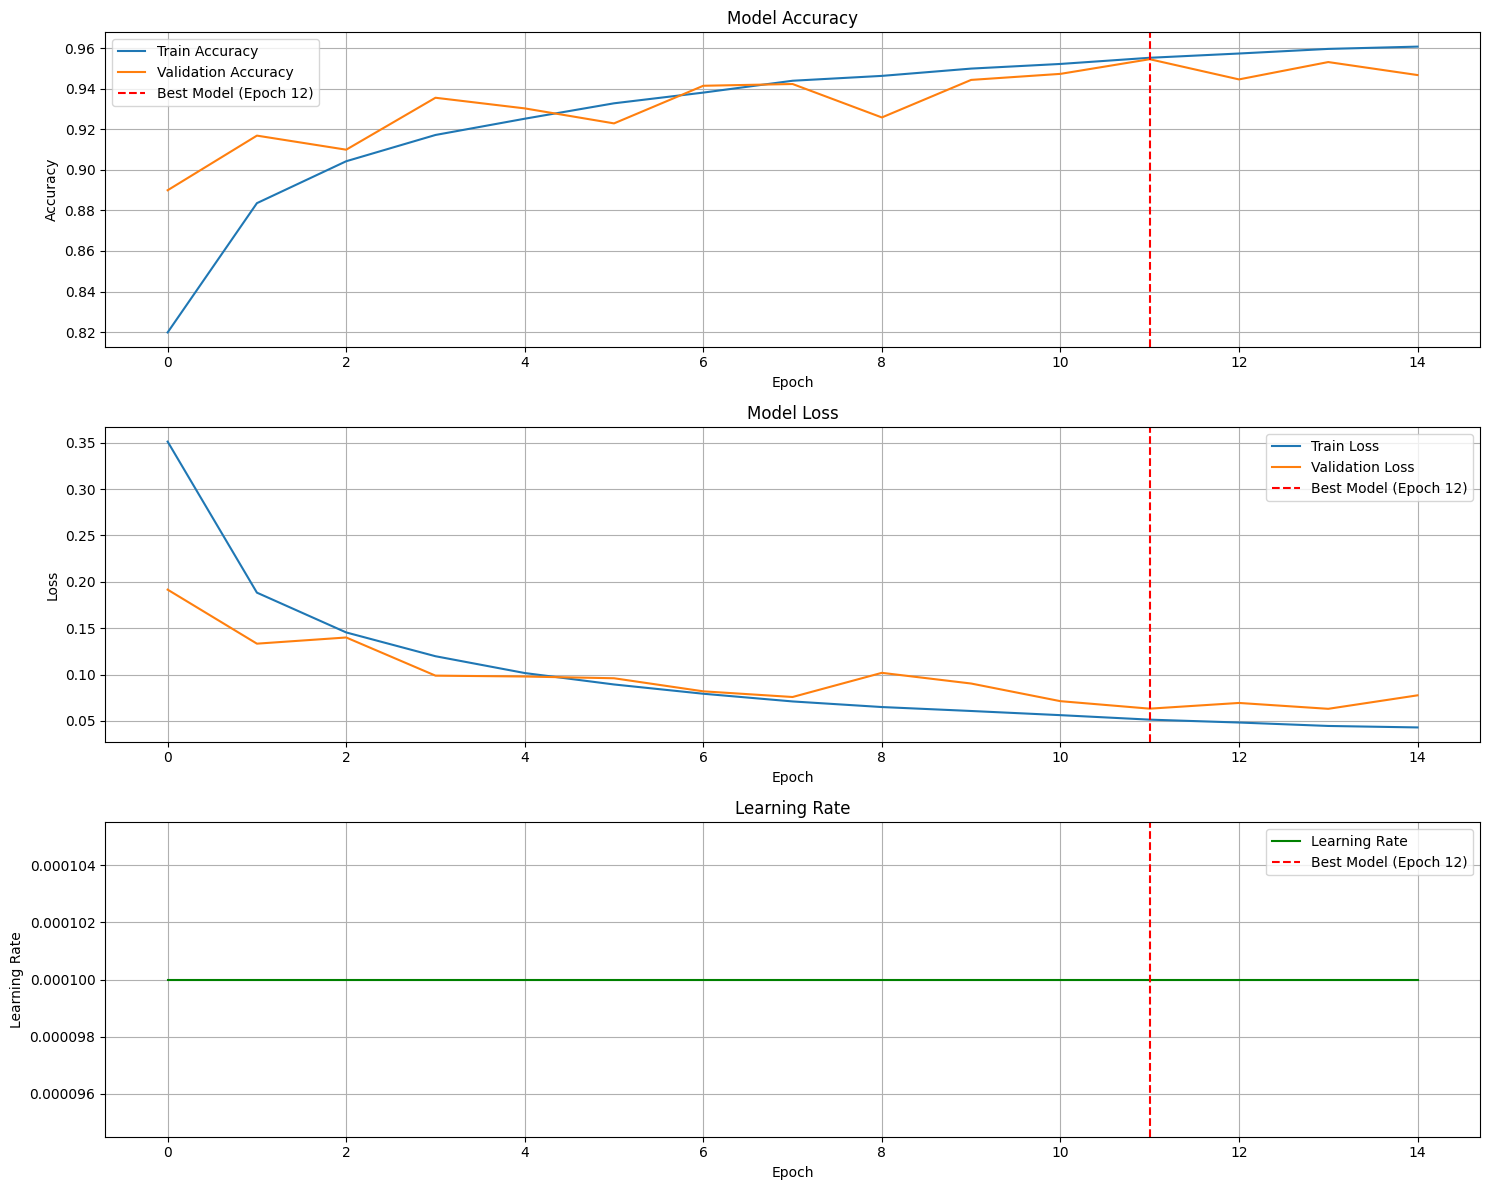


📊 Training History:
Epoch | Train Loss |  Train Acc |   Val Loss |    Val Acc |         LR
-----------------------------------------------------------------
    1 |     0.3512 |     0.8198 |     0.1915 |     0.8899 | 0.00010000
    2 |     0.1883 |     0.8836 |     0.1333 |     0.9168 | 0.00010000
    3 |     0.1454 |     0.9042 |     0.1399 |     0.9099 | 0.00010000
    4 |     0.1197 |     0.9172 |     0.0988 |     0.9355 | 0.00010000
    5 |     0.1016 |     0.9252 |     0.0978 |     0.9303 | 0.00010000
    6 |     0.0893 |     0.9328 |     0.0960 |     0.9229 | 0.00010000
    7 |     0.0793 |     0.9380 |     0.0819 |     0.9414 | 0.00010000
    8 |     0.0710 |     0.9439 |     0.0757 |     0.9423 | 0.00010000
    9 |     0.0649 |     0.9463 |     0.1018 |     0.9258 | 0.00010000
   10 |     0.0607 |     0.9499 |     0.0903 |     0.9443 | 0.00010000
   11 |     0.0562 |     0.9522 |     0.0713 |     0.9473 | 0.00010000
   12 |     0.0513 |     0.9552 |     0.0632 |     0.9545 | 0

Validating: 100%|██████████| 1514/1514 [00:47<00:00, 32.07it/s]


Best model validation accuracy: 0.9545

Best_model Classification Report:
                                                 precision    recall  f1-score   support

                                       abutment       0.90      0.96      0.93       100
                                          Crown       0.95      0.88      0.91      1561
                                    post - core       0.92      0.91      0.92       139
                                     metal band       0.99      1.00      1.00       100
                              permanentretainer       0.98      0.99      0.99       100
                           orthodontic brackets       1.00      1.00      1.00       102
                                         Caries       0.95      0.95      0.95      2742
                                          decay       0.96      0.94      0.95       100
                                     deep decay       0.90      0.97      0.93       120
                                   

In [ ]:
if __name__ == "__main__":
    try:
        model, history, mapping = train_model(
            dataset_path=dataset_path,
            batch_size=16,
            epochs=15,
            learning_rate=0.0001,
            focal_loss_gamma=2.0
        )
        print("✅ Training pipeline completed successfully!")

    except Exception as e:
        print(f"❌ Training pipeline failed: {str(e)}")
        import traceback
        traceback.print_exc()

Test dataset class

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import json
import cv2
from collections import defaultdict
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from sklearn.metrics import average_precision_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score
import seaborn as sns
import random
import io
from PIL import Image
class TestDentalDataset(Dataset):
    """PyTorch Dataset for dental X-ray testing with additional return info"""
    def __init__(self, annotations, images_dir, transform=None):
        self.annotations = annotations
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]

        # Load image
        img_path = os.path.join(self.images_dir, ann['img_file'])
        image = cv2.imread(img_path)
        original_image = image.copy() if image is not None else None

        if image is None:
            # Return a dummy image if loading fails
            image = np.zeros((224, 224, 3), dtype=np.uint8)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Crop with bounding box
            x, y, w, h = map(int, ann['bbox'])
            cropped = image[y:y+h, x:x+w]

            if cropped.size == 0:
                image = np.zeros((224, 224, 3), dtype=np.uint8)
            else:
                image = cv2.resize(cropped, (224, 224))

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        # Convert label to tensor
        label = ann['label_idx']

        return image, label, img_path, ann['bbox'], original_image
def load_annotations(annotation_path):
    """Load annotations from JSON file"""
    with open(annotation_path, 'r') as f:
        data = json.load(f)

    # Create mappings
    cat_id_to_name = {cat['id']: cat['name'] for cat in data['categories']}
    img_id_to_file = {img['id']: img['file_name'] for img in data['images']}

    # Process annotations
    annotations = []
    for ann in data['annotations']:
        annotations.append({
            'img_file': img_id_to_file[ann['image_id']],
            'bbox': ann['bbox'],
            'category_id': ann['category_id']
        })

    return annotations, data['categories'], cat_id_to_name

def prepare_datasets(dataset_path, batch_size=16):
    """Prepare training and validation datasets"""

    # Load annotations
    annotation_path = os.path.join(dataset_path, 'train', '_annotations_augmented.json')
    images_dir = os.path.join(dataset_path, 'train')

    annotations, categories, cat_id_to_name = load_annotations(annotation_path)

    # Map category IDs to indices
    unique_cat_ids = sorted(set(ann['category_id'] for ann in annotations))
    cat_id_to_idx = {cat_id: idx for idx, cat_id in enumerate(unique_cat_ids)}
    num_classes = len(unique_cat_ids)

    # Count samples per class for class weights
    class_counts = defaultdict(int)
    for ann in annotations:
        cat_id = ann['category_id']
        class_counts[cat_id] += 1

    # Calculate class weights for balanced training
    total_samples = len(annotations)
    class_weights = {cat_id: total_samples / (len(class_counts) * count)
                    for cat_id, count in class_counts.items()}

    # Print class distribution
    print("Class distribution in dataset:")
    for cat_id, count in class_counts.items():
        name = cat_id_to_name.get(cat_id, f"Unknown ({cat_id})")
        print(f"  {name}: {count} samples ({count/total_samples*100:.1f}%)")

    # Update annotations with label indices
    for ann in annotations:
        ann['label_idx'] = cat_id_to_idx[ann['category_id']]

    # Split data
    train_anns, val_anns = train_test_split(annotations, test_size=0.2, random_state=42,
                                           stratify=[ann['category_id'] for ann in annotations])

    # Define transforms with data augmentation for training
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create datasets
    train_dataset = DentalDataset(train_anns, images_dir, transform=train_transform)
    val_dataset = DentalDataset(val_anns, images_dir, transform=val_transform)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, num_classes, cat_id_to_idx, cat_id_to_name, class_weights

def prepare_test_dataset(dataset_path, batch_size=16):
    """Prepare test dataset"""

    # Load annotations
    annotation_path = os.path.join(dataset_path, 'test', '_annotations.json')
    images_dir = os.path.join(dataset_path, 'test')

    # Check if test set exists, otherwise use validation from training data
    if not os.path.exists(annotation_path):
        annotation_path = os.path.join(dataset_path, 'train', '_annotations_augmented.json')
        images_dir = os.path.join(dataset_path, 'train')
        print("Test set not found, using validation split from training data")

    annotations, categories, cat_id_to_name = load_annotations(annotation_path)

    # Map category IDs to indices
    unique_cat_ids = sorted(set(ann['category_id'] for ann in annotations))
    cat_id_to_idx = {cat_id: idx for idx, cat_id in enumerate(unique_cat_ids)}
    num_classes = len(unique_cat_ids)

    # Count samples per class
    class_counts = defaultdict(int)
    for ann in annotations:
        cat_id = ann['category_id']
        class_counts[cat_id] += 1

    # Print class distribution
    total_samples = len(annotations)
    print("Class distribution in test dataset:")
    for cat_id, count in class_counts.items():
        name = cat_id_to_name.get(cat_id, f"Unknown ({cat_id})")
        print(f"  {name}: {count} samples ({count/total_samples*100:.1f}%)")

    # Update annotations with label indices
    for ann in annotations:
        ann['label_idx'] = cat_id_to_idx[ann['category_id']]

    # If using training data, split into test
    if 'test' not in annotation_path:
        _, test_anns = train_test_split(annotations, test_size=0.2, random_state=42,
                                       stratify=[ann['category_id'] for ann in annotations])
    else:
        test_anns = annotations

    # Define transforms
    test_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create datasets
    test_dataset = TestDentalDataset(test_anns, images_dir, transform=test_transform)

    # Create dataloaders
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return test_loader, num_classes, cat_id_to_idx, cat_id_to_name
def calculate_map(y_true, y_pred, cat_id_to_name, idx_to_cat_id, outputs=None):
    """Calculate mean Average Precision (mAP)"""

    # If we have raw outputs, use them for AP calculation
    if outputs is not None:
        # Convert outputs to numpy array if needed
        if not isinstance(outputs, np.ndarray):
            outputs = np.array(outputs)

        # Number of classes
        num_classes = outputs.shape[1]

        # Convert labels to one-hot encoding
        y_true_one_hot = np.zeros((len(y_true), num_classes))
        for i, label in enumerate(y_true):
            y_true_one_hot[i, label] = 1

        # Calculate AP for each class
        ap_per_class = {}
        for cls_idx in range(num_classes):
            if np.sum(y_true_one_hot[:, cls_idx]) > 0:  # Only calculate if the class appears in ground truth
                class_ap = average_precision_score(y_true_one_hot[:, cls_idx], outputs[:, cls_idx])

                # Get class name
                if cls_idx in idx_to_cat_id:
                    class_name = cat_id_to_name[idx_to_cat_id[cls_idx]]
                else:
                    class_name = f"Class {cls_idx}"

                ap_per_class[class_name] = class_ap

        # Calculate mAP
        mAP = np.mean(list(ap_per_class.values()))

        # Print results
        print(f"\n📊 Mean Average Precision (mAP): {mAP:.4f}")

        # Print AP for each class
        print("\n📊 Average Precision per class:")
        for class_name, ap in sorted(ap_per_class.items(), key=lambda x: x[1], reverse=True):
            print(f"{class_name}: {ap:.4f}")

        # Visualize AP per class
        plt.figure(figsize=(12, 8))

        # Sort classes by AP
        sorted_ap = sorted(ap_per_class.items(), key=lambda x: x[1], reverse=True)
        classes = [item[0] for item in sorted_ap]
        aps = [item[1] for item in sorted_ap]

        # Create bar chart
        plt.bar(range(len(classes)), aps, align='center', alpha=0.7)

        # Add AP value labels
        for i, ap in enumerate(aps):
            plt.text(i, ap + 0.02, f"{ap:.3f}", ha='center', va='bottom', rotation=0)

        # Add labels
        plt.xticks(range(len(classes)), classes, rotation=45, ha='right')
        plt.ylabel('Average Precision')
        plt.title('Average Precision per Class')
        plt.ylim(0, 1.1)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        plt.tight_layout()

        # Save the plot to a file
        plt.savefig('average_precision_per_class_resnet50.png', dpi=300, bbox_inches='tight')
        plt.close()

        return mAP, ap_per_class

    else:
        # Without raw outputs, we can only approximate mAP using classification accuracy per class
        print("\n⚠️ Note: Raw model outputs not provided. Using class precision as approximation.")

        # Calculate precision, recall, and f1-score per class
        precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)

        # Get class names
        class_names = []
        unique_labels = sorted(set(y_true) | set(y_pred))
        for label in unique_labels:
            if label in idx_to_cat_id:
                class_names.append(cat_id_to_name[idx_to_cat_id[label]])
            else:
                class_names.append(f"Class {label}")

        # Calculate approximate mAP as average of precision scores
        mAP = np.mean(precision)

        # Create dictionary of class-wise precision
        ap_per_class = {class_name: prec for class_name, prec in zip(class_names, precision)}

        # Print results
        print(f"\n📊 Approximate Mean Average Precision (mAP): {mAP:.4f}")

        # Print precision for each class
        print("\n📊 Precision per class:")
        for class_name, prec in sorted(ap_per_class.items(), key=lambda x: x[1], reverse=True):
            print(f"{class_name}: {prec:.4f}")

        # Visualize precision per class
        plt.figure(figsize=(12, 8))

        # Sort classes by precision
        sorted_prec = sorted(zip(class_names, precision), key=lambda x: x[1], reverse=True)
        classes = [item[0] for item in sorted_prec]
        precs = [item[1] for item in sorted_prec]

        # Create bar chart
        plt.bar(range(len(classes)), precs, align='center', alpha=0.7)

        # Add precision value labels
        for i, prec in enumerate(precs):
            plt.text(i, prec + 0.02, f"{prec:.3f}", ha='center', va='bottom', rotation=0)

        # Add labels
        plt.xticks(range(len(classes)), classes, rotation=45, ha='right')
        plt.ylabel('Precision')
        plt.title('Precision per Class (mAP approximation)')
        plt.ylim(0, 1.1)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        plt.tight_layout()

        # Save the plot to a file
        plt.savefig('precision_per_class_resnet50.png', dpi=300, bbox_inches='tight')
        plt.close()

        return mAP, ap_per_class

def visualize_predictions(model, test_loader, cat_id_to_name, idx_to_cat_id, device, num_samples=5):
    """Visualize sample predictions with bounding boxes for ground truth and predictions"""

    model.eval()

    # Get random samples
    sample_indices = random.sample(range(len(test_loader.dataset)), num_samples)

    plt.figure(figsize=(15, 5*num_samples))

    with torch.no_grad():
        for idx, sample_idx in enumerate(sample_indices):
            image, label, img_path, bbox, original_image = test_loader.dataset[sample_idx]

            # Skip if original image is None
            if original_image is None:
                continue

            # Get prediction
            input_tensor = image.unsqueeze(0).to(device)
            outputs = model(input_tensor)
            _, pred = torch.max(outputs, 1)
            pred_idx = pred.item()

            # Get class names
            true_class = cat_id_to_name[idx_to_cat_id[label]] if label in idx_to_cat_id else f"Class {label}"
            pred_class = cat_id_to_name[idx_to_cat_id[pred_idx]] if pred_idx in idx_to_cat_id else f"Class {pred_idx}"

            # Create visualization with ground truth
            plt.subplot(num_samples, 2, idx*2 + 1)
            img_with_gt = original_image.copy()
            x, y, w, h = map(int, bbox)
            cv2.rectangle(img_with_gt, (x, y), (x+w, y+h), (0, 255, 0), 3)
            cv2.putText(img_with_gt, f"GT: {true_class}", (x, y-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            plt.imshow(cv2.cvtColor(img_with_gt, cv2.COLOR_BGR2RGB))
            plt.title('Ground Truth')
            plt.axis('off')

            # Create visualization with prediction
            plt.subplot(num_samples, 2, idx*2 + 2)
            img_with_pred = original_image.copy()
            color = (0, 255, 0) if pred_idx == label else (0, 0, 255)
            cv2.rectangle(img_with_pred, (x, y), (x+w, y+h), color, 3)
            cv2.putText(img_with_pred, f"Pred: {pred_class}", (x, y-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
            plt.imshow(cv2.cvtColor(img_with_pred, cv2.COLOR_BGR2RGB))
            plt.title('Prediction')
            plt.axis('off')

    plt.tight_layout()
    plt.savefig('prediction_comparison_resnet50.png', dpi=300, bbox_inches='tight')
    plt.close()


Displaying: individual_class_confusion_matrices_resnet50_1.png


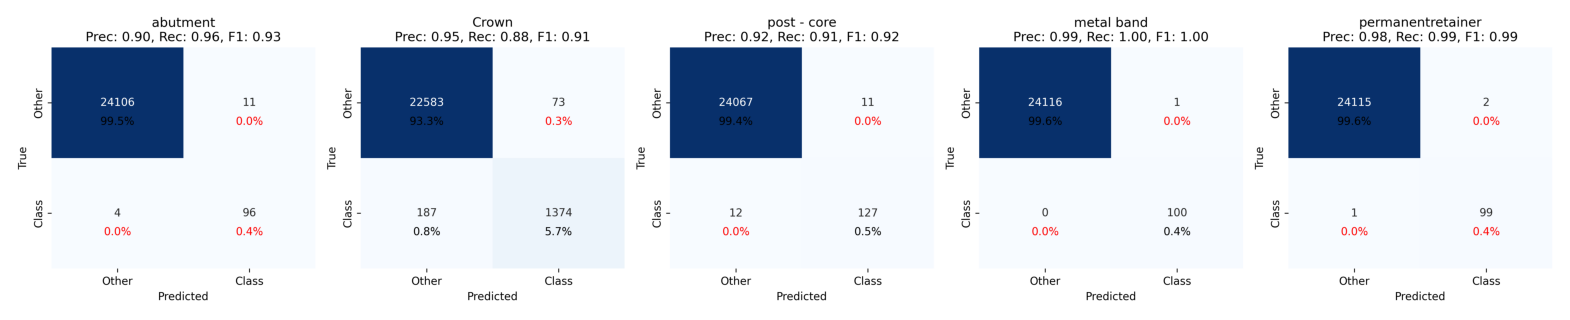

Displaying: individual_class_confusion_matrices_resnet50_2.png


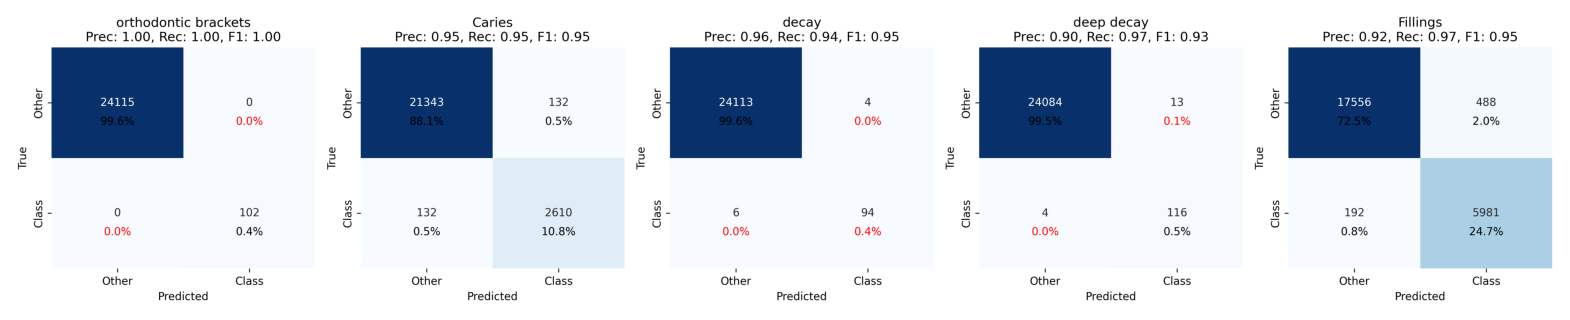

Displaying: individual_class_confusion_matrices_resnet50_3.png


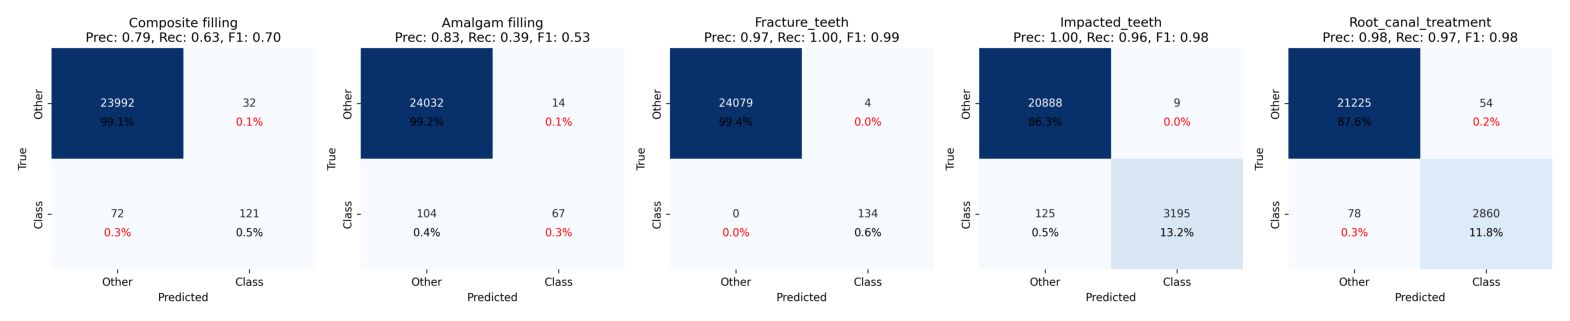

Displaying: individual_class_confusion_matrices_resnet50_4.png


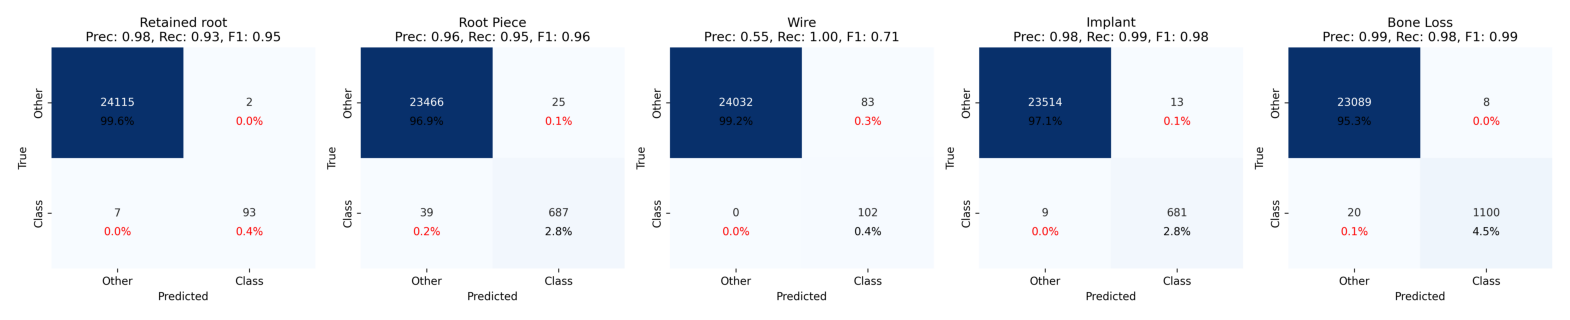

Displaying: individual_class_confusion_matrices_resnet50_5.png


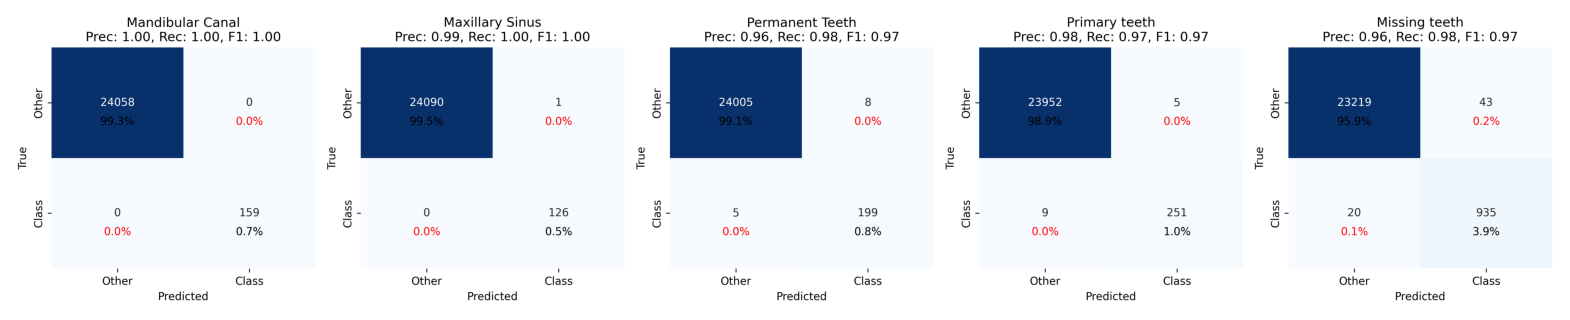

Displaying: individual_class_confusion_matrices_resnet50_6.png


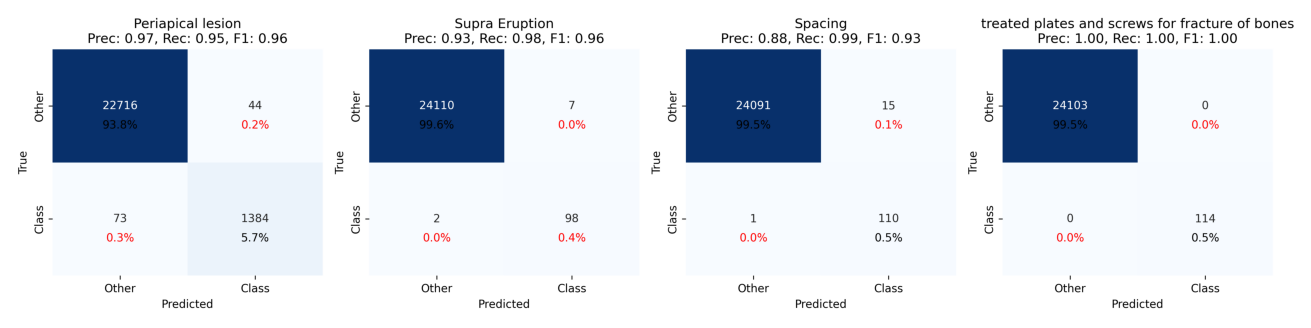

In [ ]:
from google.colab import files
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Display all the generated confusion matrix images
for img_file in sorted(glob.glob('individual_class_confusion_matrices_resnet50_*.png')):
    print(f"Displaying: {img_file}")
    img = mpimg.imread(img_file)
    plt.figure(figsize=(20, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
def plot_per_class_confusion_matrix(y_true, y_pred, cat_id_to_name, idx_to_cat_id):
    """Plot confusion matrix for each class individually, 5 per figure"""
    print("Starting to generate individual class confusion matrices...")

    # Get unique labels from both y_true and y_pred
    unique_labels = sorted(set(y_true) | set(y_pred))
    print(f"Found {len(unique_labels)} unique classes to analyze")

    # Calculate overall confusion matrix with all possible labels
    cm = confusion_matrix(y_true, y_pred, labels=unique_labels)

    # Split into multiple figures, 5 classes per figure
    classes_per_fig = 5
    n_figures = (len(unique_labels) + classes_per_fig - 1) // classes_per_fig
    print(f"Will generate {n_figures} figures with up to {classes_per_fig} classes each")

    for fig_idx in range(n_figures):
        print(f"Generating figure {fig_idx + 1} of {n_figures}...")
        plt.figure(figsize=(20, 4))
        start_idx = fig_idx * classes_per_fig
        end_idx = min(start_idx + classes_per_fig, len(unique_labels))

        for i, label_idx in enumerate(unique_labels[start_idx:end_idx]):
            plt.subplot(1, classes_per_fig, i + 1)

            # Find position of this label in the confusion matrix
            label_pos = unique_labels.index(label_idx)

            # Extract 2x2 matrix for this class (binary classification: this class vs all others)
            true_positives = cm[label_pos, label_pos]
            false_positives = sum(cm[:, label_pos]) - true_positives
            false_negatives = sum(cm[label_pos, :]) - true_positives
            true_negatives = sum(sum(cm)) - true_positives - false_positives - false_negatives

            binary_cm = np.array([[true_negatives, false_positives],
                                  [false_negatives, true_positives]])

            # Calculate metrics
            precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
            recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

            # Get class name
            class_name = cat_id_to_name[idx_to_cat_id[label_idx]] if label_idx in idx_to_cat_id else f"Class {label_idx}"
            print(f"  - Processing class: {class_name}")

            # Plot
            sns.heatmap(binary_cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=['Other', 'Class'],
                        yticklabels=['Other', 'Class'],
                        cbar=False)
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title(f'{class_name}\n'
                     f'Prec: {precision:.2f}, Rec: {recall:.2f}, F1: {f1:.2f}', fontsize=12)

            # Add percentages as annotation
            total = sum(sum(binary_cm))
            for y in range(2):
                for x in range(2):
                    plt.text(x + 0.5, y + 0.7, f'{100 * binary_cm[y, x] / total:.1f}%',
                            horizontalalignment='center',
                            color='red' if binary_cm[y, x] < 100 else 'black',
                            fontsize=10)

        plt.tight_layout()

        # Save the figure with explicit path
        filename = f'individual_class_confusion_matrices_resnet50_{fig_idx+1}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"  Saved figure to {filename}")

        plt.close()

    print("Completed generating all individual class confusion matrices!")

Testing function

In [ ]:
def test_model(dataset_path, model_path='best_model_resnet50.pth', batch_size=16):
    """Comprehensive test function for ResNet50 model"""

    print("🔄 Preparing test dataset...")
    test_loader, num_classes, cat_id_to_idx, cat_id_to_name = prepare_test_dataset(dataset_path, batch_size)
    idx_to_cat_id = {v: k for k, v in cat_id_to_idx.items()}

    # Load model
    print("🔄 Loading model...")
    model = ResNet50Model(num_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Define criterion
    criterion = FocalLoss(gamma=2.0)

    # Evaluate on test set
    print("🔄 Evaluating on test set...")
    test_loss = 0.0
    test_corrects = 0
    total_samples = 0

    all_preds = []
    all_labels = []
    all_outputs = []  # Store raw model outputs for mAP calculation

    with torch.no_grad():
        for inputs, labels, *_ in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            test_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())  # Store raw outputs

    test_loss = test_loss / total_samples
    test_acc = test_corrects.double() / total_samples

    print(f"\n📊 Test Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    # Generate overall confusion matrix
    print("\n🔄 Generating overall confusion matrix...")
    plot_confusion_matrix(all_labels, all_preds, cat_id_to_name, cat_id_to_idx, idx_to_cat_id, "test")

    # NEW: Generate individual class confusion matrices
    print("\n🔄 Generating individual class confusion matrices...")
    plot_per_class_confusion_matrix(all_labels, all_preds, cat_id_to_name, idx_to_cat_id)

    # Calculate mean Average Precision (mAP)
    print("\n🔄 Calculating mean Average Precision (mAP)...")
    mAP, ap_per_class = calculate_map(all_labels, all_preds, cat_id_to_name, idx_to_cat_id, all_outputs)

    # Visualize sample predictions
    print("\n🔄 Visualizing sample predictions...")
    visualize_predictions(model, test_loader, cat_id_to_name, idx_to_cat_id, device)

    # Save test results
    test_results = {
        'test_loss': test_loss,
        'test_accuracy': test_acc,
        'predictions': all_preds,
        'labels': all_labels,
        'classification_report': classification_report(
            all_labels, all_preds,
            target_names=[cat_id_to_name[idx_to_cat_id[i]] if i in idx_to_cat_id else f"Class {i}"
                         for i in sorted(set(all_labels) | set(all_preds))],
            labels=sorted(set(all_labels) | set(all_preds)),
            output_dict=True
        ),
        'mAP': mAP,
        'ap_per_class': ap_per_class
    }

    with open('test_results_resnet50.pkl', 'wb') as f:
        pickle.dump(test_results, f)

    print("\n✅ Testing completed successfully!")
    print(f"Final test accuracy: {test_acc:.4f}")
    print(f"Mean Average Precision (mAP): {mAP:.4f}")

    return test_results

Run the testing

In [ ]:
def run_testing():
    try:
        dataset_path = '/content/drive/MyDrive/Final_processed_dataset'

        print("\n🔄 Starting model testing...")
        test_results = test_model(
            dataset_path=dataset_path,
            model_path='best_model_resnet50.pth',
            batch_size=16
        )
        print("✅ Testing completed successfully!")
        return test_results

    except Exception as e:
        print(f"❌ Testing failed: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Main execution - you can comment out whichever part you don't need
if __name__ == "__main__":
    # Comment out this line if you only want to test
    # model, history, mapping = run_training()

    # Comment out this line if you only want to train
    test_results = run_testing()


🔄 Starting model testing...
🔄 Preparing test dataset...
Test set not found, using validation split from training data
Class distribution in test dataset:
  Fillings: 30862 samples (25.5%)
  Crown: 7805 samples (6.4%)
  Root_canal_treatment: 14688 samples (12.1%)
  Mandibular Canal: 793 samples (0.7%)
  Maxillary Sinus: 629 samples (0.5%)
  Bone Loss: 5598 samples (4.6%)
  Impacted_teeth: 16598 samples (13.7%)
  Periapical lesion: 7285 samples (6.0%)
  Root Piece: 3631 samples (3.0%)
  Caries: 13712 samples (11.3%)
  Missing teeth: 4777 samples (3.9%)
  Implant: 3448 samples (2.8%)
  Composite filling: 964 samples (0.8%)
  Amalgam filling: 856 samples (0.7%)
  abutment: 502 samples (0.4%)
  post - core: 696 samples (0.6%)
  Primary teeth: 1298 samples (1.1%)
  Fracture_teeth: 671 samples (0.6%)
  orthodontic brackets: 512 samples (0.4%)
  deep decay: 599 samples (0.5%)
  Wire: 512 samples (0.4%)
  Permanent Teeth: 1021 samples (0.8%)
  Spacing: 556 samples (0.5%)
  decay: 500 samples (

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🔄 Evaluating on test set...


Testing: 100%|██████████| 1514/1514 [02:08<00:00, 11.82it/s]



📊 Test Results:
Test Loss: 0.0632
Test Accuracy: 0.9545

🔄 Generating overall confusion matrix...

📊 Test Classification Report:
                                                 precision    recall  f1-score   support

                                       abutment       0.90      0.96      0.93       100
                                          Crown       0.95      0.88      0.91      1561
                                    post - core       0.92      0.91      0.92       139
                                     metal band       0.99      1.00      1.00       100
                              permanentretainer       0.98      0.99      0.99       100
                           orthodontic brackets       1.00      1.00      1.00       102
                                         Caries       0.95      0.95      0.95      2742
                                          decay       0.96      0.94      0.95       100
                                     deep decay       0.90      0.97